In [1]:
# Import libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Step 1: Load the data

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

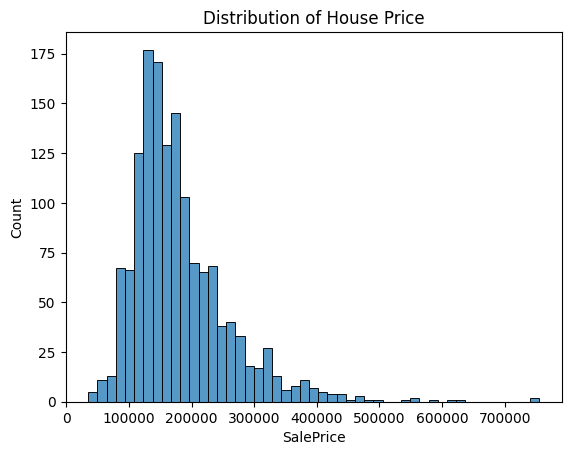

In [2]:
train_data_path = "../input/house-prices-advanced-regression-techniques/train.csv"
train_df = pd.read_csv(train_data_path)

train_df.head(3)

# drop the unnecessary column
train_df = train_df.drop('Id', axis=1)
train_df

# check the target data
plt.title("Distribution of House Price")
sns.histplot(train_df.SalePrice, kde=False)
train_df['SalePrice'].describe()

## Step 2. Cleaning the dataset

In [3]:
num_rows= len(train_df)

# drop the column with more 10% of the null values
train_df.dropna(thresh=num_rows*0.9,axis=1, inplace = True)

# replace any null value with zero (to use all housing data)
train_df.fillna(0, inplace=True)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

## Step 3. Preprocessing

In [4]:
# find numeric and non-numeric columns

# set target column
output_col = ['SalePrice']

# save the total column names 
total_cols = train_df.columns

# find the input columns
input_cols = list(set(total_cols) - set(output_col))
print(f"total {len(input_cols)} columsn are input for the regression model")
    
# save the column number info
input_size = len(input_cols)
output_size = len(output_col)
    
def convert_to_all_numeric_df(df):
    
    # Make a copy of the original dataframe
    df1 = df.copy(deep=True)
    
    # save the total column names 
    total_cols = df1.columns

    # find categorical columns 
    numeric_cols = df1._get_numeric_data().columns
    categorical_cols = list(set(total_cols) - set(numeric_cols))
    print(f"Among them, {len(categorical_cols)} columns are categorical: {categorical_cols}")

    #convert non-numeric catogerical columns to numeric 
    for col in categorical_cols:
        df1[col] = df1[col].astype('category').cat.codes
    
    # check zero and NaN
    print(f"Total number of NaN in the datasets : {df1.isna().sum()}")
    print(f"Total number of 0 in the datasets : {(df1 == 0.00).sum()}")
    
    return df1
   
    
train_df1 = convert_to_all_numeric_df(train_df)

total 72 columsn are input for the regression model
Among them, 37 columns are categorical: ['GarageType', 'BsmtCond', 'SaleCondition', 'ExterCond', 'PavedDrive', 'LandSlope', 'GarageQual', 'Foundation', 'BsmtQual', 'Functional', 'Exterior2nd', 'Neighborhood', 'BsmtFinType1', 'BsmtFinType2', 'Condition2', 'RoofStyle', 'BsmtExposure', 'Exterior1st', 'BldgType', 'Electrical', 'Heating', 'GarageFinish', 'LotConfig', 'HouseStyle', 'LotShape', 'HeatingQC', 'GarageCond', 'KitchenQual', 'Street', 'ExterQual', 'MSZoning', 'RoofMatl', 'Utilities', 'LandContour', 'SaleType', 'Condition1', 'CentralAir']
Total number of NaN in the datasets : MSSubClass       0
MSZoning         0
LotArea          0
Street           0
LotShape         0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 73, dtype: int64
Total number of 0 in the datasets : MSSubClass         0
MSZoning          10
LotArea            0
Street             6
LotShape

In [5]:
# As preprocessing, the target value, SalePrice will be converted to Million unit. 
train_df1[output_col] = train_df1[output_col]/1.e6

# Create input and output data
X = train_df1[input_cols].to_numpy()
y = train_df1[output_col].to_numpy()

# split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

input_scaler = preprocessing.StandardScaler()

# preprocessing input using built-in Scaler 
X_train = input_scaler.fit_transform(X_train)
X_test = input_scaler.transform(X_test)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Step 4. Initialize the model

In [6]:
# Set parameters
param = {
    'max_depth': 3,
    'eta': 0.2,
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 3,
    'subsample': 1.0,
    'colsample_bytree': 0.5,
}

# Train the model
num_round = 100
bst = xgb.train(param, dtrain, num_round)




# Step 5. Predict the model

(438,) (438,)
438 438
MSE: 0.0189
RMSE: 0.1375
Correlation Coefficient: 0.9259


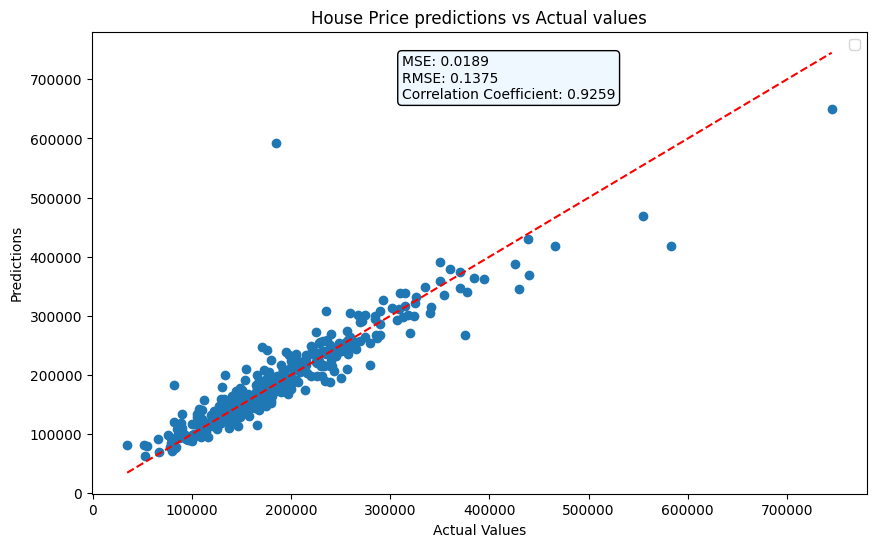

In [7]:
# Predict
predictions = bst.predict(dtest)

print(predictions.shape, y_test[:,0].shape)


# convert the price from million $ to $
predictions = [x * 1.e6 for x in predictions] 
actual_values = [x * 1.e6 for x in y_test[:,0]] 

print(len(predictions), len(actual_values))

log_predicted = np.log1p(np.array(predictions))
log_actual = np.log1p(np.array(actual_values))

# Calculate key statistics
MSE = np.mean((log_predicted - log_actual)**2 )
RMSE = np.sqrt(MSE)
R  = np.corrcoef(predictions, actual_values)[0,1]

stats_text = f'MSE: {MSE:.4f}\nRMSE: {RMSE:.4f}\nCorrelation Coefficient: {R:.4f}'
print(stats_text)

# plot the predictions and actual_values
plt.figure(figsize = (10,6))

plt.scatter(actual_values,  predictions)
# Add the 1:1 line
min_val = min(min(actual_values), min(predictions))
max_val = max(max(actual_values), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')


# Adding the key statistics on the plot
plt.text(0.4, 0.95, stats_text, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))
    
    
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('House Price predictions vs Actual values')
plt.legend()
plt.show()

## Submission

In [8]:
test_file = '../input/house-prices-advanced-regression-techniques/test.csv'
test_df = pd.read_csv(test_file)

print(test_df.shape)

# placeholder for output column
test_df['SalePrice'] = 0.

test_df.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,0.0
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,0.0
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,0.0
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,0.0
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,0.0


In [9]:
# apply the same cleaning/preprocessing methods to the test data

# first, save id columns for output
test_ids = test_df.pop('Id')

# remove the columns unused
test_df = pd.concat([test_df[input_cols], test_df[output_col]], axis =1) 

# replace any null values with zero 
test_df.fillna(0, inplace = True)

# convert all columns to numerical df
test_df1 = convert_to_all_numeric_df(test_df)

# Create input and output data
X = test_df1[input_cols].to_numpy()
y = test_df1[output_col].to_numpy()

# preprocessing input using built-in Scaler 
X_scaled = input_scaler.transform(X)

# Convert data to DMatrix format for XGBoost
dsample = xgb.DMatrix(X_scaled, label=y)

# Predict
predictions = bst.predict(dsample)

print(predictions.shape)


# convert the price from million $ to $
predictions = [x * 1.e6 for x in predictions] 

print(len(predictions))


# save the output
output = pd.DataFrame( {'Id': test_ids,
                       'SalePrice': predictions })

output.head()

Among them, 37 columns are categorical: ['GarageType', 'BsmtCond', 'SaleCondition', 'ExterCond', 'PavedDrive', 'LandSlope', 'GarageQual', 'Foundation', 'BsmtQual', 'Functional', 'Exterior2nd', 'Neighborhood', 'BsmtFinType1', 'BsmtFinType2', 'Condition2', 'RoofStyle', 'BsmtExposure', 'Exterior1st', 'BldgType', 'Electrical', 'GarageFinish', 'Heating', 'LotConfig', 'HouseStyle', 'LotShape', 'HeatingQC', 'GarageCond', 'KitchenQual', 'Street', 'ExterQual', 'MSZoning', 'RoofMatl', 'Utilities', 'SaleType', 'LandContour', 'Condition1', 'CentralAir']
Total number of NaN in the datasets : GarageType       0
OverallCond      0
MSSubClass       0
SaleCondition    0
KitchenAbvGr     0
                ..
LandContour      0
WoodDeckSF       0
Condition1       0
CentralAir       0
SalePrice        0
Length: 73, dtype: int64
Total number of 0 in the datasets : GarageType         76
OverallCond         0
MSSubClass          0
SaleCondition      89
KitchenAbvGr        2
                 ... 
LandContour 

,Id,SalePrice
0,1461,120416.536927
1,1462,159354.597330
2,1463,178710.877895
3,1464,170021.444559
4,1465,181354.269385


In [10]:
submit_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
submit_df['SalePrice'] = predictions  

submit_df.to_csv('/kaggle/working/submission.csv',index=False)
submit_df.head()

,Id,SalePrice
0,1461,120416.536927
1,1462,159354.597330
2,1463,178710.877895
3,1464,170021.444559
4,1465,181354.269385
